In [98]:
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import keras
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Activation, Conv1D, MaxPooling1D

%matplotlib inline

In [99]:
data_list = os.listdir('data/')

In [100]:
CURDIR = os.getcwd()
DATADIR = os.path.join(CURDIR, 'data')

In [101]:
type(data_list)

list

In [102]:
data_list[10]

'03-01-01-01-01-01-11.wav'

In [103]:
data_list[10][6:-16]

'01'

In [104]:
data, sampling_rate = librosa.load(os.path.join(DATADIR, data_list[10]))

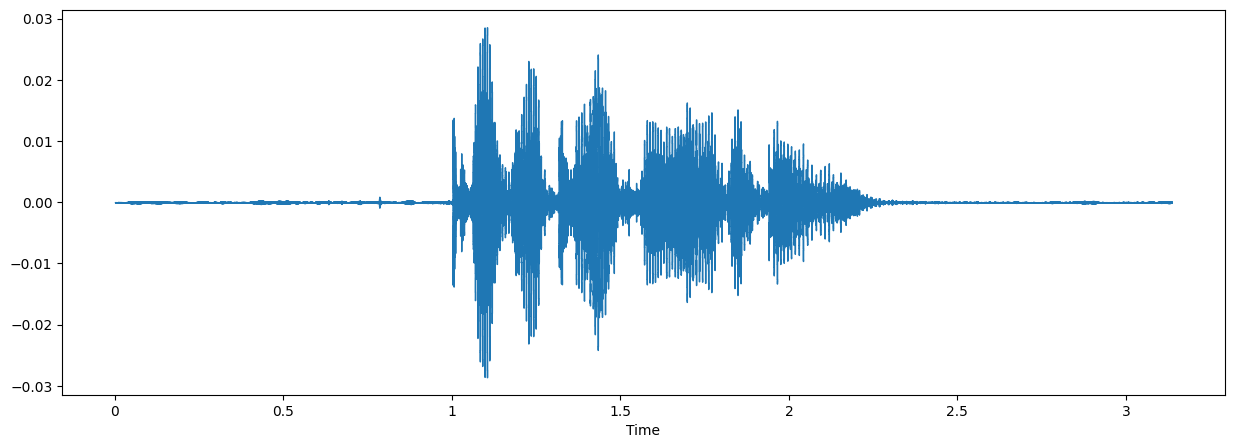

In [105]:
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)
plt.show()

In [106]:
# tone_dict={'01':'neutral',
#              '02':'calm',
#              '03':'happy',
#              '04':'sad',
#              '05':'angry',
#              '06':'fearful',
#              '07':'disgust',
#              '08':'surprised'}

In [107]:
df_0=pd.DataFrame(columns=['item', 'gender', 'tone'])
tone_dict={'02':'calm','03':'happy','04':'sad','05':'angry','06':'fearful'}
gender_dict={0:'female',1:'male'}

In [108]:
tone_dict.get('02')

'calm'

In [109]:
for item in data_list:
    gender=gender_dict.get(int(item[18:-4])%2)
    try:
        tone=tone_dict.get(item[6:-16])
        df_0.loc[len(df_0.index)] = [item, gender, tone] 
    except:
        pass

In [110]:
df_0.dropna(inplace=True)
df_0.reset_index(drop=True, inplace=True)

In [111]:
df_0.head()

,item,gender,tone
0,03-01-02-01-01-01-01.wav,male,calm
1,03-01-02-01-01-01-02.wav,female,calm
2,03-01-02-01-01-01-03.wav,male,calm
3,03-01-02-01-01-01-04.wav,female,calm
4,03-01-02-01-01-01-05.wav,male,calm


In [112]:
data = list(df_0['item'])

In [113]:
type(data)

list

## Getting the features

In [114]:
import os
import numpy as np
import pandas as pd
import librosa

df_1 = pd.DataFrame()

# Define the column names for the DataFrame
columns = [f'mfcc_{i}' for i in range(13)] + [f'chroma_{i}' for i in range(12)] + [f'spectral_contrast_{i}' for i in range(7)]

# Process each audio file and extract features
for index, y in enumerate(data):
    # Load the audio file
    y, sr = librosa.load(os.path.join(DATADIR, y), sr=22050)  # Adjust sr as needed
    
    # Extract MFCC features
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)
    
    # Extract Chroma features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)
    
    # Extract Spectral Contrast features
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    spectral_contrast_mean = np.mean(spectral_contrast, axis=1)
    
    # Combine all features into a single feature vector
    features = np.concatenate((mfccs_mean, chroma_mean, spectral_contrast_mean))
    
    
    # Create a DataFrame for the current features
    features_df = pd.DataFrame([features], columns=columns)
    
    # Append the features to the main DataFrame
    df_1 = pd.concat([df_1, features_df], ignore_index=True)




In [115]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_1[columns] = scaler.fit_transform(df_1[columns])

In [116]:
labels = []
for index in range(df_0.shape[0]):
    label = df_0['gender'][index] +'_'+ df_0['tone'][index]
    labels.append(label)

In [117]:
X_train, X_test, y_train, y_test = train_test_split(df_1, labels, test_size=0.2, random_state=10)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

lb = LabelEncoder()

y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

# Expand dimensions for CNN input
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)


In [120]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Define your model
model = Sequential()

model.add(Conv1D(128, 5, padding='same', input_shape=(32, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Conv1D(64, 5, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv1D(64, 5, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(64, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(10))
model.add(Activation('softmax'))

# Compile the model with Adam optimizer and categorical crossentropy loss
model.compile(optimizer=Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

# Implement early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(x_traincnn, y_train, batch_size=16, epochs=1000, 
                    validation_data=(x_testcnn, y_test), callbacks=[early_stop])

# Evaluate the model
loss, accuracy = model.evaluate(x_testcnn, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_47 (Conv1D)          (None, 32, 128)           768       
                                                                 
 batch_normalization_36 (Bat  (None, 32, 128)          512       
 chNormalization)                                                
                                                                 
 activation_77 (Activation)  (None, 32, 128)           0         
                                                                 
 dropout_55 (Dropout)        (None, 32, 128)           0         
                                                                 
 conv1d_48 (Conv1D)          (None, 32, 64)            41024     
                                                                 
 batch_normalization_37 (Bat  (None, 32, 64)           256       
 chNormalization)                                    

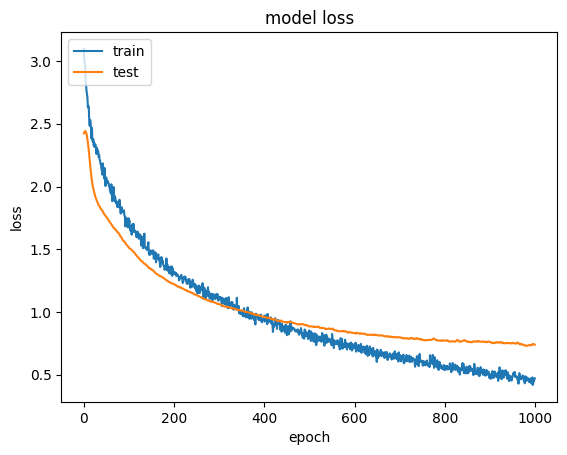

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()